Литинская, Симонова, Ялугина

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time


import xgboost as xgb
from xgboost import XGBRegressor

from datetime import date

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

import warnings
warnings.filterwarnings("ignore")


from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression, Lasso, Ridge

import pickle

from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector

from itertools import combinations
import time

import model_processing
from model_processing import *
from sklearn.metrics import mean_absolute_error as mae

from tqdm import tqdm
from copy import deepcopy
from itertools import product

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

import xgboost as xgb
from xgboost import XGBRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [157]:
data = pd.read_excel('data_ts_project.xlsx')

## Исходные данные

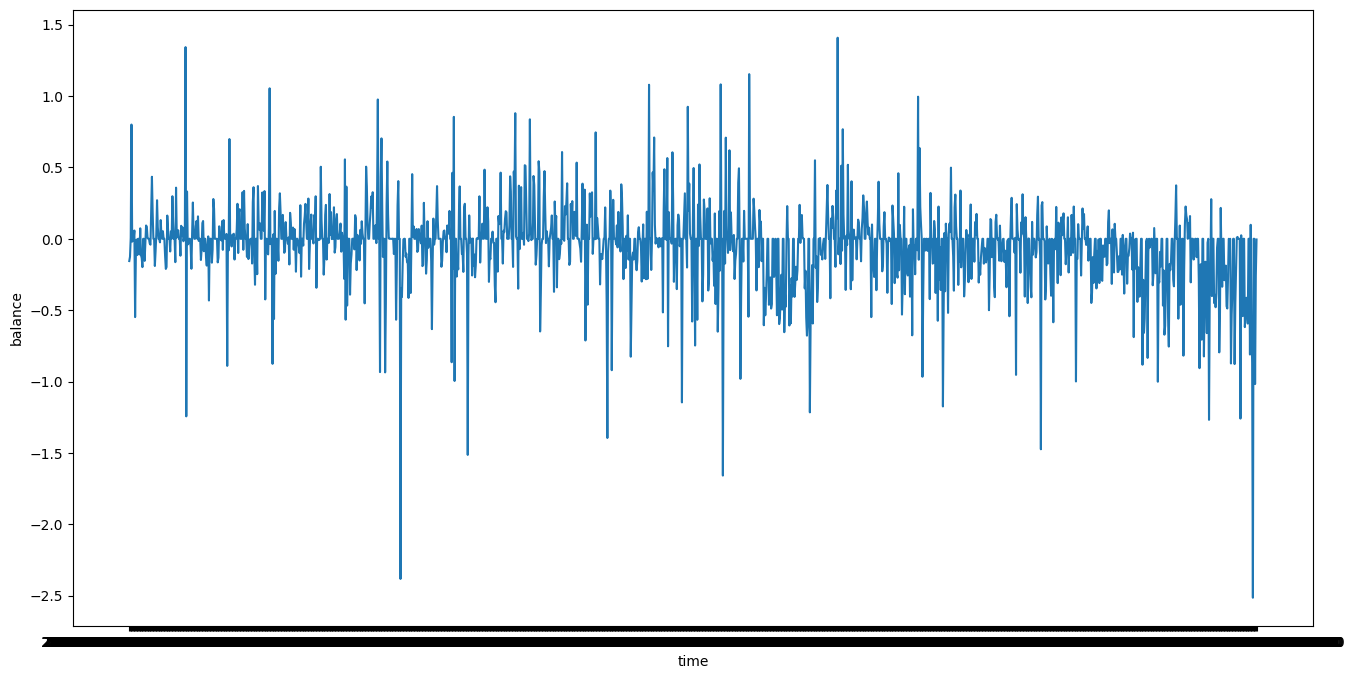

In [ ]:
# график исходных данных
plt.figure(figsize=(16,8))
plt.plot(data['Date'], data['Balance'])
plt.xlabel('time')
plt.ylabel('balance')
plt.show()

In [ ]:
# функции для проверки ряда на стационарность
def adfuller_summary(X, alpha: float):
  result = adfuller(X)
  print('Результат проверки критерия Дики-Фуллера:')
  if (alpha > 1) or (alpha < 0):
    print('уровень значимости некорректно задан')
  else:
    if result[1] <= alpha:
      print('ряд стационарен')
    else:
      print('ряд не стационарен')

def kpss_test(x, alpha: float, h0_type="c"):
    kpss_test = kpss(x, regression=h0_type)
    print('Результат проверки критерия KPSS:')
    if (alpha > 1) | (alpha < 0):
      print('уровень значимости некорректно задан')
    else:
      if kpss_test[1] >= alpha:
        print('ряд стационарен')
      else:
        print('ряд не стационарен')

In [ ]:
adfuller_summary(data['Balance'], 0.01)
kpss_test(data['Balance'], 0.01)

Результат проверки критерия Дики-Фуллера:
ряд стационарен
Результат проверки критерия KPSS:
ряд стационарен


При заданном уровне значимости ряд является стационарным.

## Добавление признаков

In [24]:
# загрузка данных с внешними признаками
macro_data = pd.read_excel('DATA.xlsx', index_col=0, parse_dates=True)
info = pd.read_excel('DATA.xlsx', sheet_name='Info')

In [ ]:
info # краткое описание признаков, входящих во внешние данные

,Column,Info,Source
0,Key_rate,%,https://www.cbr.ru/hd_base/infl/?UniDbQuery.Po...
1,CPI,"consumer price indices for goods and services,...",https://rosstat.gov.ru/statistics/price
2,GDP,"2021 prices, bn rubbles, quarterly data, no se...",https://rosstat.gov.ru/statistics/accounts
3,Unemploy_rate,"total unemployment rate, %",https://rosstat.gov.ru/labour_force
4,Exchange_rate,USD/RUB,https://ru.investing.com/currencies/usd-rub-hi...
5,MOEX_index,close,https://www.moex.com/ru/index/IMOEX/archive?fr...
6,Bond_yield,"zero-coupon yield curve for government bonds, ...",https://www.cbr.ru/hd_base/zcyc_params/?UniDbQ...
7,Tax_day,NaN,https://www.consultant.ru/document/cons_doc_LA...
8,Reserves,Mandatory reserves subject to averaging in cor...,https://www.cbr.ru/hd_base/RReserves/?UniDbQue...


Добавим к данным календарные признаки, а также лаги:
  * день недели
  * месяц
  * квартал
  * выходной
  * праздник
  * сокращенный рабочий день
  * лаги на дни

In [25]:
# загрузка данных о производственном календаре
holiday = pd.read_excel('holiday.xlsx', index_col=0, parse_dates=True)

In [26]:
# функция подготовки данных
def prepare_data(data: pd.DataFrame(), calendar: pd.DataFrame(), macro: pd.DataFrame(), lags: list, test_size: float):

    data = pd.DataFrame(data.copy())
    calendar = pd.DataFrame(calendar.copy())
    macro = pd.DataFrame(macro.copy())

    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # добавляем календарные признаки

    weekday = pd.get_dummies(data.index.weekday,prefix='weekday', dtype=float).set_index(data.index)
    weekday['weekend'] = weekday['weekday_5'] + weekday['weekday_6']
    month = pd.get_dummies(data.index.month, prefix='month', dtype=float).set_index(data.index)
    quarter = pd.get_dummies(data.index.quarter, prefix='quarter', dtype=float).set_index(data.index)

    holiday = pd.get_dummies(calendar.iloc[:, 0], dtype=float)
    holiday = holiday.rename(columns={1: 'holiday', 2: 'short_day'})

    events = weekday.merge(month, how='outer', on='Date')
    events = events.merge(quarter, how='outer', on='Date')
    events = events.drop(labels=['weekday_5', 'weekday_6', 'month_12', 'quarter_4'], axis=1)
    events = events.merge(holiday, how='outer', on='Date')
    events = events.fillna(0)

    ext_data = macro.merge(events, how='outer', on='Date')
    data = data.merge(ext_data, how='outer', on='Date')

    # добавляем лаги исходного ряда в качестве признаков
    for ll in lags:
        data['lag_{}'.format(ll)] = data.Balance.shift(ll)

    data = data.fillna(0)

    # делим выборку на тренировочную и тестовую

    data_train = data.iloc[:int(data.shape[0]*(1-test_size))]
    data_test = data.iloc[int(data.shape[0]*(1-test_size)):]

    X_train, X_test = data_train.drop(['Balance'], axis=1), data_test.drop(['Balance'], axis=1)
    y_train, y_test = data_train['Balance'], data_test['Balance']

    for i, j in zip([X_train, X_test], [y_train, y_test]):

      # RMSE (отклонение значения ряда от среднего)
      i['rmse'] = np.sqrt((j - j.mean()) ** 2)

      # Синус значений ряда
      i['sin_value'] = np.sin(j)

    X_train, X_test, y_train, y_test = X_train.fillna(0), X_test.fillna(0), y_train.fillna(0), y_test.fillna(0)

    X_train = X_train.drop(labels=['Income', 'Outcome'], axis=1)
    X_test = X_test.drop(labels=['Income', 'Outcome'], axis=1)

    return X_train, X_test, y_train, y_test

Иллюстрация влияние лагов на значения временного ряда с помощью графиков ACF и PACF.

Text(0.5, 0, 'lags')

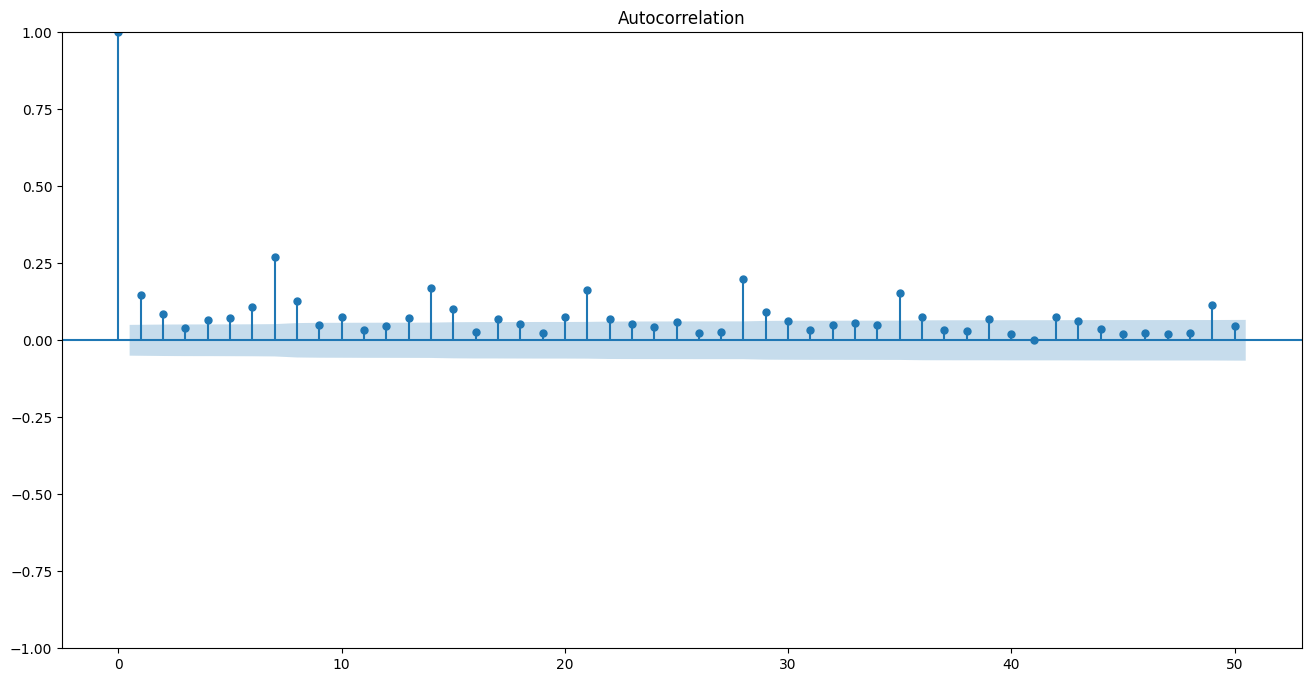

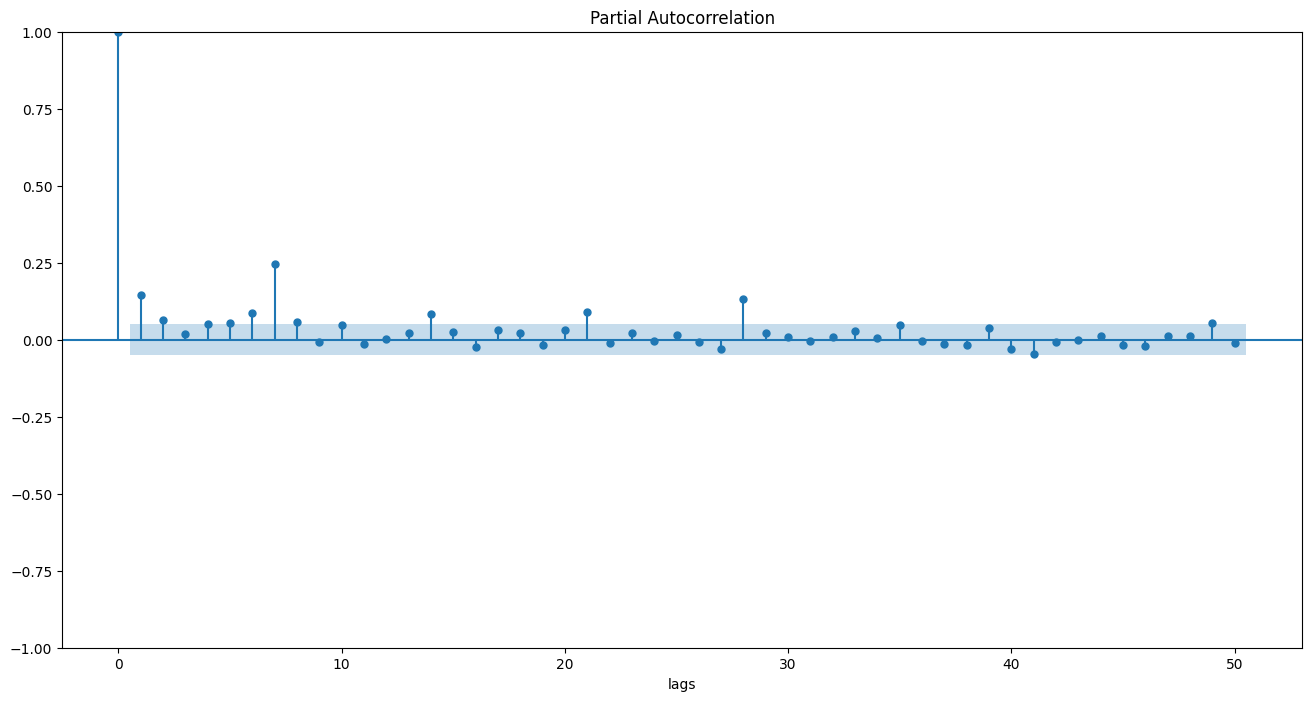

In [27]:
plt.rc("figure", figsize=(16,8))
fig_1 = plot_acf(data['Balance'].values.squeeze(), lags=50)
fig_2 = plot_pacf(data['Balance'].values.squeeze(), lags=50)
plt.xlabel('lags')

## Отбор признаков

In [28]:
# функции для сравнения стабильности отбора признаков
def jaccard_index(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

def stability_score(selected_features_list):
    n = len(selected_features_list)
    scores = []
    for i, j in combinations(range(n), 2):
      scores.append(jaccard_index(set(selected_features_list[i]), set(selected_features_list[j])))
    return np.mean(scores)

In [29]:
# модуль отбора признаков
def useful_data_only(trainx_data: pd.DataFrame(), trainy_data: pd.DataFrame()):

  # Определяем размер батча
  batch_size = int(0.7 * len(trainx_data))
  num_batches = 6

  # Генерируем случайные начальные индексы для каждого батча
  start_indices = np.random.randint(0, len(trainx_data) - batch_size + 1, size=num_batches)

  # Создаем батчи
  batches_X = []
  batches_y = []

  for start in start_indices:
    end = start + batch_size
    batches_X.append(trainx_data.iloc[start:end])
    batches_y.append(trainy_data.iloc[start:end])

  # методы фильтрации

  results = {}

  # KBest, SelectPercentile

  for i in np.arange(6, 11, 1):
    storage = []
    for batch_x, batch_y in zip(batches_X, batches_y):
      filtr_2 = SelectKBest(score_func=f_regression, k=i) # f_regression
      useful_f_2 = filtr_2.fit_transform(batch_x, batch_y)
      selected_indices = filtr_2.get_support(indices=True)
      selected_features = batch_x.columns[selected_indices]
      storage.append(selected_features)
    results[f'SKBf_{i}'] = stability_score(storage)

  for i in np.arange(6, 11, 1):
    storage = []
    for batch_x, batch_y in zip(batches_X, batches_y):
      filtr_3 = SelectKBest(score_func=mutual_info_regression, k=i) # mutual_info_regression, нелинейная зависимость
      useful_f_3 = filtr_3.fit_transform(batch_x, batch_y)
      selected_indices = filtr_3.get_support(indices=True)
      selected_features = batch_x.columns[selected_indices]
      storage.append(selected_features)
    results[f'SKBmir_{i}'] = stability_score(storage)

  for i in np.arange(10, 26, 5):
    storage = []
    for batch_x, batch_y in zip(batches_X, batches_y):
      filtr_4 = SelectPercentile(score_func=f_regression, percentile=i) # f_regression
      useful_f_4 = filtr_4.fit_transform(batch_x, batch_y)
      selected_indices = filtr_4.get_support(indices=True)
      selected_features = batch_x.columns[selected_indices]
      storage.append(selected_features)
    results[f'SPf_{i}'] = stability_score(storage)

  for i in np.arange(10, 26, 5):
    storage = []
    for batch_x, batch_y in zip(batches_X, batches_y):
      filtr_5 = SelectPercentile(score_func=mutual_info_regression, percentile=i) # mutual_info_regression, нелинейная зависимость
      useful_f_5 = filtr_5.fit_transform(batch_x, batch_y)
      selected_indices = filtr_5.get_support(indices=True)
      selected_features = batch_x.columns[selected_indices]
      storage.append(selected_features)
    results[f'SPmir_{i}'] = stability_score(storage)

  # встроенные методы

  # ARD, Bayesian regression

  storage_1 = []
  storage_2 = []
  for batch_x, batch_y in zip(batches_X, batches_y):
    brr = BayesianRidge(compute_score=True, max_iter=30).fit(batch_x, batch_y)
    ard = ARDRegression(compute_score=True, max_iter=30).fit(batch_x, batch_y)
    df = pd.DataFrame(
        {   "feature_name": trainx_data.columns,
            "ARDRegression": list(ard.coef_),
             "BayesianRidge": list(brr.coef_),
         }
     )

    useful_f_6 = df.loc[df['ARDRegression'] > 0.01]['feature_name'].to_list()
    useful_f_7 = df.loc[df['BayesianRidge'] > 0.01]['feature_name'].to_list()

    storage_1.append(useful_f_6)
    storage_2.append(useful_f_7)

  results[f'ARDR'] = stability_score(storage_1)
  results[f'BR'] = stability_score(storage_2)

  # оберточные методы

  # Forward selection

  regressor = LinearRegression()

  for i in np.arange(6, 11, 1):
    feature_selector = SequentialFeatureSelector(regressor,
            n_features_to_select=i,
            direction='forward',
            cv=5)
    storage = []
    for batch_x, batch_y in zip(batches_X, batches_y):
      sfs = feature_selector.fit(batch_x, batch_y)
      useful_f_8 = np.array(a.columns)[sfs.get_support()]
      storage.append(useful_f_8)
    results[f'SFSf_{i}'] = stability_score(storage)

  # Backward selection

  for i in np.arange(6, 11, 1):
    feature_selector = SequentialFeatureSelector(regressor,
            n_features_to_select=i,
            direction='backward',
            cv=5)
    storage = []
    for batch_x, batch_y in zip(batches_X, batches_y):
      sfs = feature_selector.fit(batch_x, batch_y)
      useful_f_9 = np.array(a.columns)[sfs.get_support()]
      storage.append(useful_f_9)
    results[f'SFSb_{i}'] = stability_score(storage)

  # SelectFromModel

  storage = []
  for batch_x, batch_y in zip(batches_X, batches_y):
    regressor = LinearRegression().fit(batch_x, batch_y)
    model = SelectFromModel(regressor, threshold='mean')
    trans = model.transform(batch_x)

    selected_indices = model.get_support(indices=True)
    selected_features = batch_x.columns[selected_indices]
    storage.append(selected_features)

  results[f'SFM'] = stability_score(storage)

  scl = []

  for i in results.keys():
    if results[i] == np.float64(1.0):
      scl.append(i)

  new_dict = {k: v for k, v in results.items() if k not in scl}
  final_model = max(new_dict, key=results.get)

  return final_model # возвращает список с названием признаков, которые должны быть включены в признаковое пространство

In [32]:
a, b, c, d = prepare_data(data, holiday, macro_data, [1, 2, 3, 4, 5, 6, 7], 0.15)

In [33]:
# функция для возвращения признаков, отобранных с помощью модели, имеющей наилучшую стабильность разбиения
def final_df(final_model: str, data_x_train: pd.DataFrame,  data_x_test: pd.DataFrame, data_y_train: pd.DataFrame):
  name = final_model.split('_')[0]
  if len(final_model.split('_')) > 1:
    i =  int(final_model.split('_')[1])

  if name == 'SKBf':
    filtr_2 = SelectKBest(score_func=f_regression, k=i)
    useful_f_2 = filtr_2.fit_transform(data_x_train, data_y_train)
    selected_indices = filtr_2.get_support(indices=True)
    selected_features_1 = data_x_train.columns[selected_indices]
    selected_features_2 = data_x_test.columns[selected_indices]
    df = pd.concat([data_x_train[selected_features_1], data_x_test[selected_features_2]])

  elif name == 'SKBmir':
    filtr_3 = SelectKBest(score_func=mutual_info_regression, k=i)
    useful_f_3 = filtr_3.fit_transform(data_x_train, data_y_train)
    selected_indices = filtr_3.get_support(indices=True)
    selected_features_1 = data_x_train.columns[selected_indices]
    selected_features_2 = data_x_test.columns[selected_indices]
    df = pd.concat([data_x_train[selected_features_1], data_x_test[selected_features_2]])

  elif name == 'SPf':
    filtr_4 = SelectPercentile(score_func=f_regression, percentile=i)
    useful_f_4 = filtr_4.fit_transform(data_x_train, data_y_train)
    selected_indices = filtr_4.get_support(indices=True)
    selected_features_1 = data_x_train.columns[selected_indices]
    selected_features_2 = data_x_test.columns[selected_indices]
    df = pd.concat([data_x_train[selected_features_1], data_x_test[selected_features_2]])

  elif name == 'SPmir':
    filtr_5 = SelectPercentile(score_func=mutual_info_regression, percentile=i)
    useful_f_5 = filtr_5.fit_transform(data_x_train, data_y_train)
    selected_indices = filtr_5.get_support(indices=True)
    selected_features_1 = data_x_train.columns[selected_indices]
    selected_features_2 = data_x_test.columns[selected_indices]
    df = pd.concat([data_x_train[selected_features_1], data_x_test[selected_features_2]])

  elif name == 'ARDR':

    ard = ARDRegression(compute_score=True, max_iter=30).fit(data_x_train, data_y_train)
    df = pd.DataFrame(
        {   "feature_name": data_x_train.columns,
            "ARDRegression": list(ard.coef_),
         }
     )

    useful_f_6 = df.loc[df['ARDRegression'] > 0.01]['feature_name'].to_list()
    selected_features_1 = data_x_train[useful_f_6]
    selected_features_2 = data_x_test[useful_f_6]
    df = pd.concat([selected_features_1, selected_features_2])

  elif name == 'BR':
    brr = BayesianRidge(compute_score=True, max_iter=30).fit(data_x_train, data_y_train)
    df = pd.DataFrame(
        {   "feature_name": data_x_train.columns,
             "BayesianRidge": list(brr.coef_),
         }
     )

    useful_f_7 = df.loc[df['BayesianRidge'] > 0.01]['feature_name'].to_list()
    selected_features_1 = data_x_train[useful_f_7]
    selected_features_2 = data_x_test[useful_f_7]
    df = pd.concat([selected_features_1, selected_features_2])

  elif name == 'SFSf':
    regressor = LinearRegression()

    feature_selector = SequentialFeatureSelector(regressor,
          n_features_to_select=i,
          direction='forward',
          cv=5)
    sfs = feature_selector.fit(data_x_train, data_y_train)
    useful_f_8 = np.array(a.columns)[sfs.get_support()]
    selected_features_1 = data_x_train[useful_f_8]
    selected_features_2 = data_x_test[useful_f_8]
    df = pd.concat([selected_features_1, selected_features_2])

  elif name == 'SFSb':
    regressor = LinearRegression()

    feature_selector = SequentialFeatureSelector(regressor,
          n_features_to_select=i,
          direction='backward',
          cv=5)
    sfs = feature_selector.fit(data_x_train, data_y_train)
    useful_f_9 = np.array(a.columns)[sfs.get_support()]
    selected_features_1 = data_x_train[useful_f_9]
    selected_features_2 = data_x_test[useful_f_9]
    df = pd.concat([selected_features_1, selected_features_2])

  elif name == 'SFM':
    regressor = LinearRegression().fit(data_x_train, data_y_train)
    model = SelectFromModel(regressor, threshold='mean')
    trans = model.transform(data_x_train)

    selected_indices = model.get_support(indices=True)
    selected_features_1 = data_x_train.columns[selected_indices]
    selected_features_2 = data_x_test.columns[selected_indices]
    df = pd.concat([data_x_train[selected_features_1], data_x_test[selected_features_2]])

  return df

In [ ]:
fdata = final_df(useful_data_only(a, c), a, b, c)

In [ ]:
fdata.to_csv('features.csv')

## Подбор гиперпараметров

Начнем с ML моделей: бустинг и случайный лес

In [158]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [159]:
#fdata = pd.read_csv('features.csv')
fdata['Date'] = pd.to_datetime(fdata['Date'])
fdata.set_index('Date', inplace=True)

KeyError: 'Date'

In [160]:
data = data.drop(columns = ['Income', 'Outcome']).merge(fdata, left_index=True, right_index=True).iloc[7:, :]

In [ ]:
# Генерим индексы окон для кросс-валидации (2 типа: sliding и expanding).
# Будем подбирать по expanding, чтобы лишний раз не "выбрасывать" данные
windows = list(win_cv(100, 15, len(data), 1, 'expanding'))

In [ ]:
# Функция поиска гиперпараметров для разных ML моделей
def params_search(model_type, windows, metric, maps):

    if model_type == 'boosting':
        params = [
                        # learning_rate
                        [0.01, 0.05, 0.1],
                        # max_depth
                        [3, 5, 8],
                        # n_estimators
                        [50, 100, 200],

                ]
        # Генерируем все возможные комбинации параметров
        params = [dict(zip(
                        ('learning_rate', 'max_depth', 'n_estimators'),
                        params
                        ))


                        for params in  product(*params)]

    elif model_type == 'random_forest':

        params = [
                        # max_depth
                        [3, 5, 8],
                        # criterion
                        ['absolute_error', 'squared_error'],
                        # min_samples_leaf
                        [5, 10, 20]

                ]
        # Генерируем все возможные комбинации параметров
        params = [dict(zip(
                        ('max_depth', 'criterion', 'min_samples_leaf'),
                        params
                        ))
                        for params in  product(*params)]
    result = []
    # Кросс-валидируемся по всем параметрам и окнам
    for param in tqdm(params):
        res = cross_val_window(data, windows, model_type, metric, [param], maps)
        result.append((param, res))
    return result

In [ ]:
exog_cols = [1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
# Проводим grid search
boosting_search = params_search('boosting', windows, mae, [[1, 2, 3, 4, 5, 6, 7, 8]])

100%|██████████| 27/27 [06:29<00:00, 14.44s/it]


In [ ]:
random_forest_search = params_search('random_forest', windows, mae, [[1, 2, 3, 4, 5, 6, 7, 8]])

100%|██████████| 18/18 [19:36<00:00, 65.36s/it]


In [ ]:
# Выбираем наборы гиперпараметров по наименьшей ошибке
best_boosting_params = min(boosting_search, key=lambda x: x[1])[0]
best_random_forest_params = min(random_forest_search, key=lambda x: x[1])[0]

In [ ]:
# Сначала ошибка среднего прогноза бустинга и леса
mae_ens = cross_val_window(data, windows, 'ensemble', mae,
            [best_random_forest_params, best_boosting_params],
            [[1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3, 4, 5, 6, 7, 8]])

# Отдельно лес
mae_forest = cross_val_window(data, windows, 'random_forest', mae, [best_random_forest_params], [[1, 2, 3, 4, 5, 6, 7, 8]])
forest_model = RandomForestRegressor(**best_random_forest_params, random_state=0)

# Отдельно бустинг
mae_boost = cross_val_window(data, windows, 'boosting', mae, [best_boosting_params], [[1, 2, 3, 4, 5, 6, 7, 8]])
boost_model = xgb.XGBRegressor(**best_boosting_params,
                               tree_method='gpu_hist',
                               predictor='gpu_predictor',
                               gpu_id=0,
                               random_state=0)

In [ ]:
def final_arima_pipeline(df, target_col='Balance', exog_cols=data.drop(columns = ['Balance', 'lag_1']).columns.to_list(), criterion='bic', test_size=0.2):
    # Проверка уровня стационарности и коинтеграции
    print("Анализ стационарности и коинтеграции:")
    mode_ARIMA = test_stationarity_and_cointegration(df, target_col, exog_cols, model_type = 'ARIMA')
    mode_ARIMAX = test_stationarity_and_cointegration(df, target_col, exog_cols, model_type = 'ARIMAX')

    # Подготовка данных
    df_ARIMA = prepare_data(df, mode_ARIMA, target_col, exog_cols)
    df_ARIMAX = prepare_data(df, mode_ARIMAX, target_col, exog_cols)

    print(f"\nПодбор ARIMA модели (без регрессоров) [{mode_ARIMA}]")
    arima_model = try_arima_models(df_ARIMA, target_col, exog_cols=None, criterion=criterion, target_type = mode_ARIMA[target_col])

    print(f"ARIMA: order={arima_model['order']}, BIC={arima_model['ic']:.2f}, MAE={arima_model['mae']:.4f}")

    print(f"\nПодбор ARIMAX модели (с регрессорами) [{mode_ARIMAX}]")
    arimax_model = try_arima_models(df_ARIMAX, target_col, exog_cols=exog_cols, criterion=criterion, target_type = mode_ARIMAX if str else mode_ARIMAX[target_col])

    print(f"ARIMAX: order={arimax_model['order']}, BIC={arimax_model['ic']:.2f}, MAE={arimax_model['mae']:.4f}")

    print("\nВыбор лучшей модели по MAE:")
    best_model = arimax_model if arimax_model['mae'] < arima_model['mae'] else arima_model
    print(f"Выбрана модель: {'ARIMAX' if best_model == arimax_model else 'ARIMA'} с MAE = {best_model['mae']:.4f}")

    return best_model

In [ ]:
econometric_ts_model = final_arima_pipeline(data.drop(columns = ['lag_1']))

Анализ стационарности и коинтеграции:
ADF test Balance: p-value=0.0009 -> стац.
ADF test Tax_day: p-value=0.0000 -> стац.
ADF test Reserves: p-value=0.9773 -> нестац.
ADF test weekday_0: p-value=0.0000 -> стац.
ADF test weekday_3: p-value=0.0000 -> стац.
ADF test lag_7: p-value=0.0001 -> стац.
ADF test rmse: p-value=0.0000 -> стац.
ADF test sin_value: p-value=0.0005 -> стац.
ADF test Balance: p-value=0.0009 -> стац.
ADF test Tax_day: p-value=0.0000 -> стац.
ADF test Reserves: p-value=0.9773 -> нестац.
ADF test weekday_0: p-value=0.0000 -> стац.
ADF test weekday_3: p-value=0.0000 -> стац.
ADF test lag_7: p-value=0.0001 -> стац.
ADF test rmse: p-value=0.0000 -> стац.
ADF test sin_value: p-value=0.0005 -> стац.
Engle-Granger тест: коинтеграция обнаружена

Подбор ARIMA модели (без регрессоров) [{'Balance': 'levels', 'Tax_day': 'levels', 'Reserves': 'diff', 'weekday_0': 'levels', 'weekday_3': 'levels', 'lag_7': 'levels', 'rmse': 'levels', 'sin_value': 'levels'}]
ARIMA: order=(5, 0, 5), BIC=

In [ ]:
model_list = {econometric_ts_model['model']: econometric_ts_model['mae'],
              boost_model: mae_boost,
              forest_model: mae_forest}

def get_best_model(model_list):

    # Поиск модели с наименьшим MAE
    best_model_name = min(model_list, key=lambda x: model_list[x])
    best_model = best_model_name  # если модель уже является значением
    best_mae = model_list[best_model_name]

    print(f"Лучшая модель: {best_model_name} с MAE = {best_mae:.4f}")
    return best_model

In [ ]:
final_model = get_best_model(model_list)

Лучшая модель: GradientBoostingRegressor(criterion='squared_error', learning_rate=0.05,
                          random_state=0) с MAE = 0.0072


## Частота калибровки

Подберем оптимальную частоту калибровки по следующему критерию: среднее MAE при разных длинах калибровочных окон. Выберем ту частоту калибровки, которая дала минимальное значение среднего MAE

In [ ]:
def find_optimal_calibration_frequency(
    df,
    target_col='Balance',
    exog_cols=[1, 2, 3, 4, 5, 6, 7, 8],
    calibration_steps=[30],
    min_train_size=100,
    test_size=30,
    criterion='bic',
):
    results = []

    for step in calibration_steps:
        mae_scores = []
        time_per_step = []
        train_end = min_train_size

        while train_end + test_size <= len(df):
            train_df = df.iloc[:train_end]

            try:
                # Замеряем время калибровки
                start_time = time.time()
                windows = list(win_cv(500, 100, len(train_df), 1, 'expanding'))
                boosting_search = params_search('boosting', windows, mean_absolute_error, [exog_cols])
                best_boosting_params = min(boosting_search, key=lambda x: x[1])[0]
                model = xgb.XGBRegressor(**best_boosting_params,
                               tree_method='gpu_hist',
                               predictor='gpu_predictor',
                               gpu_id=0,
                               random_state=0)
                model.fit(train_df.iloc[:, exog_cols], train_df[target_col])
                calibration_time = time.time() - start_time

                # Валидация
                calib_df = df.iloc[train_end:train_end+test_size]
                y_pred = model.predict(calib_df.iloc[:, exog_cols])
                mae = mean_absolute_error(calib_df[target_col], y_pred)

                mae_scores.append(mae)
                time_per_step.append(calibration_time)

            except Exception as e:
                print(f"Error for step {step}: {str(e)}")

            train_end += step

        if mae_scores:
            # Нормированные метрики (чем меньше - тем лучше)
            avg_mae = np.mean(mae_scores)
            avg_time = np.mean(time_per_step)
            total_calibrations = len(mae_scores)

            results.append({
                'calibration_step': step,
                'mae': avg_mae,
                'time_per_calib': avg_time,
                'total_calibrations': total_calibrations
            })

    if not results:
        raise ValueError("No valid calibration frequencies found")

    # Сортируем по комбинированному критерию
    results.sort(key=lambda x: x['mae'])

    # Выводим топ-3 варианта
    print("Top calibration frequencies:")
    for res in results[:3]:
        print(f"Step {res['calibration_step']}: MAE={res['mae']:.5f}, Time={res['time_per_calib']:.2f}s, "
              f"Calibrations={res['total_calibrations']}")

    return results

In [ ]:
calib_info = find_optimal_calibration_frequency(
    data,
    target_col='Balance',
    exog_cols=[1, 2, 3, 4, 5, 6, 7, 8],
    calibration_steps=[30, 60, 100, 180, 360],
    min_train_size=1000,
    test_size=30,
    criterion='bic',
)

100%|██████████| 27/27 [00:42<00:00,  1.56s/it]


Top calibration frequencies:
Step 30: MAE=0.00908, Time=36.78s, Calibrations=17
Step 180: MAE=0.00967, Time=32.85s, Calibrations=3
Step 60: MAE=0.01300, Time=36.48s, Calibrations=9


Несмотря на чуть больший средний MAE при калибровке в 30 дней (разница в 4 знаке после запятой) по сравнению с калибровкой каждые 180 дней, оставновимся на 2 варианте из соображения экономии ресурсов (кол-во калибровок сокращается в 5 раз).

In [36]:
calibration_dates = pd.date_range(start='2017-05-01', end='2021-03-01', freq='6MS')

In [ ]:
# Создаем временную папку, если её нет
os.makedirs('/content/models', exist_ok=True)

exog_cols = [1, 2, 3, 4, 5, 6, 7, 8]
for calibration_date in calibration_dates:
    sample = data[data.index<calibration_date]
    X_train = sample.iloc[:, 1:]
    y_train = sample.iloc[:, 0]
    windows = list(win_cv(100, 30, len(X_train), 1, 'expanding'))
    boosting_search = params_search('boosting', windows, mean_absolute_error, [exog_cols])
    best_boosting_params = min(boosting_search, key=lambda x: x[1])[0]
    model = xgb.XGBRegressor(**best_boosting_params,
                               tree_method='gpu_hist',
                               predictor='gpu_predictor',
                               gpu_id=0,
                               random_state=0)

    model.fit(X_train, y_train)
    # Сохраняем модель во временную папку /models/ для переиспользования
    filename = f'/content/models/Model_{calibration_date.strftime("%B")}_{calibration_date.year}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

    print(f"Модель сохранена: {filename}")

100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


Модель сохранена: /content/models/Model_May_2017.pkl


100%|██████████| 27/27 [00:40<00:00,  1.49s/it]


Модель сохранена: /content/models/Model_November_2017.pkl


100%|██████████| 27/27 [00:59<00:00,  2.21s/it]


Модель сохранена: /content/models/Model_May_2018.pkl


100%|██████████| 27/27 [01:21<00:00,  3.03s/it]


Модель сохранена: /content/models/Model_November_2018.pkl


100%|██████████| 27/27 [01:47<00:00,  3.96s/it]


Модель сохранена: /content/models/Model_May_2019.pkl


100%|██████████| 27/27 [02:10<00:00,  4.84s/it]


Модель сохранена: /content/models/Model_November_2019.pkl


100%|██████████| 27/27 [02:39<00:00,  5.90s/it]


Модель сохранена: /content/models/Model_May_2020.pkl


100%|██████████| 27/27 [03:24<00:00,  7.59s/it]

Модель сохранена: /content/models/Model_November_2020.pkl


# Поиск аномалий

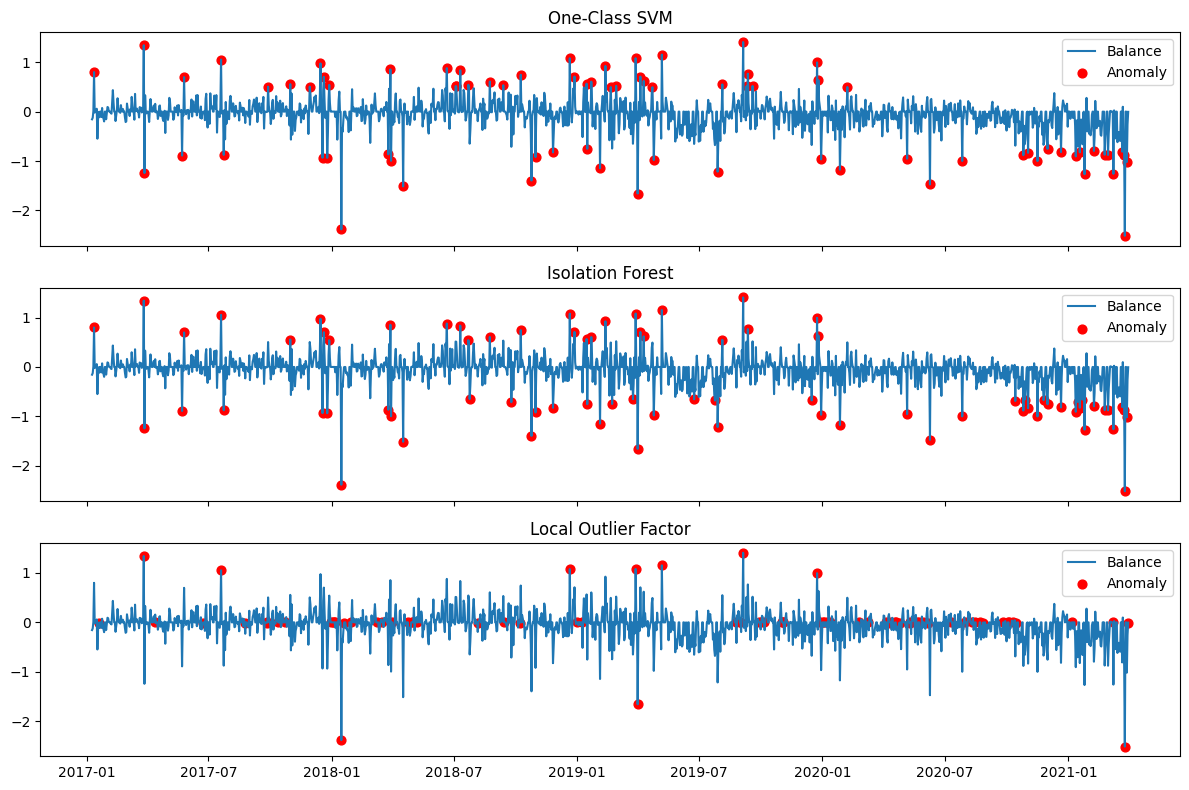

In [ ]:

df = data
initial = df
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Подготовим данные
np.random.seed(42)

df.set_index("Date", inplace=True)

X = df[["Balance"]].values

# Определим алгоритмы выявления аномалий
outliers_fraction = 0.05
anomaly_algorithms = {
    "One-Class SVM": OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1),
    "Isolation Forest": IsolationForest(contamination=outliers_fraction, random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction)
}

# Store predictions
results = {}

for name, model in anomaly_algorithms.items():
    if name == "Local Outlier Factor":
        y_pred = model.fit_predict(X)
    else:
        model.fit(X)
        y_pred = model.predict(X)
    results[name] = y_pred

# Plot results for each algorithm
fig, axs = plt.subplots(len(anomaly_algorithms), 1, figsize=(12, 8), sharex=True)
for ax, (name, preds) in zip(axs, results.items()):
    ax.plot(df.index, df["Balance"], label="Balance")
    ax.scatter(df.index[preds == -1], df["Balance"][preds == -1], color="red", label="Anomaly", s=40)
    ax.set_title(name)
    ax.legend()

plt.tight_layout()
plt.show()



Результаты для One-Class SVM и Isolation Forest очень схожи, однако One-Class SVM выделяет больше точек как аномалии, возможно имеет место перееобучение, излишняя подстройка под существующие данные. LOF выделяет как выбросы многие точки, которые явно таковыми не являются, и наооборот, не помечает как аномалии многие наблюдения, которые явно отличаются от общего ряда.  В связи с этим, кажется, что наиболее подходящей моделью для поиска аномалий здесь является Isolation Forest – его предсказания выглядят наиболее логичными.

В конце ряда мы видим, что многие точки промечаются как аномалии. Возможно, имело место изменение общего тренда модели или появление разладки, поэтому нужно проверить данные на наличие таковых.

In [ ]:
model = IsolationForest(contamination=outliers_fraction, random_state=42)
y_pred = model.fit_predict(X)
anomalies = []
for i in y_pred:
    if i == -1:
        anomalies.append(1)
    else:
        anomalies.append(0)

# Выявление разладок

Populating the interactive namespace from numpy and matplotlib


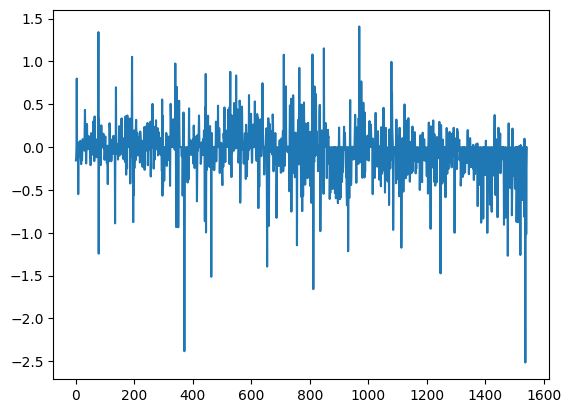

In [ ]:
%pylab inline
plot(X)


## Linearly penalized segmentation (Pelt)

In [ ]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.6 MB/s eta 0:00:00


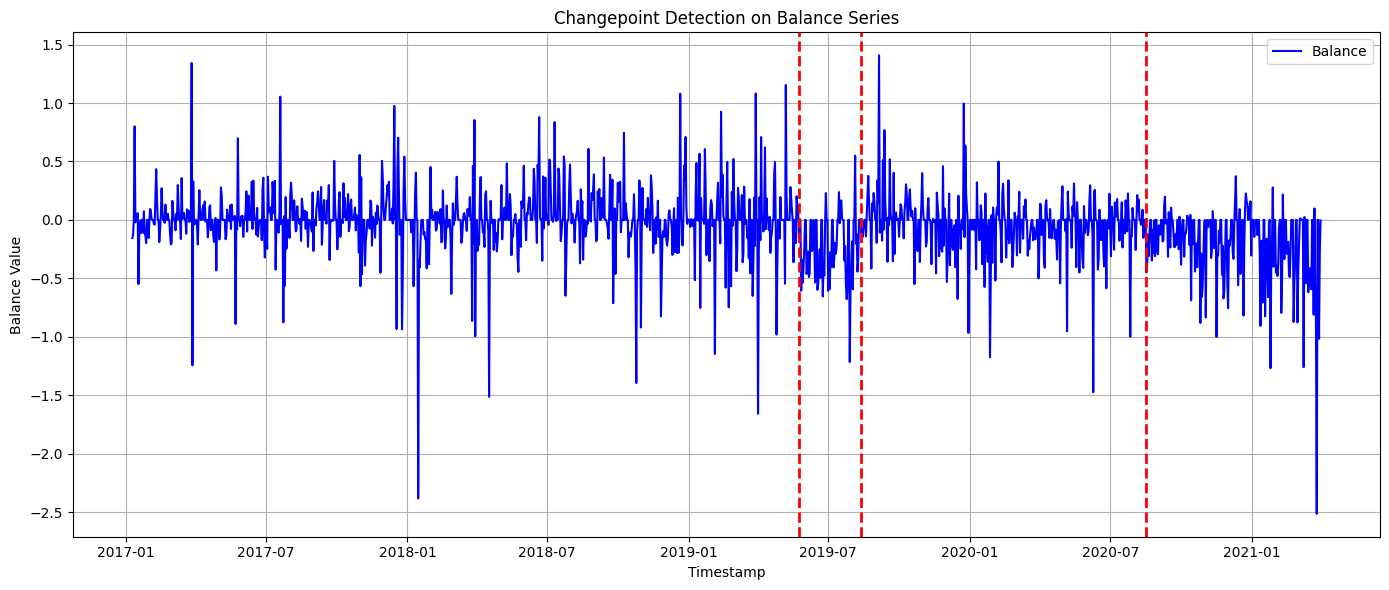

In [136]:

# 1) достаем данные

values, timestamps = [], []

for i in df.reset_index()['Date']:
    timestamps.append(i)
    values.append(df['Balance'][i])

# 2) выявляем разладки
signal = np.array(df['Balance'])
model = rpt.Pelt(model="rbf").fit(signal)
result = model.predict(pen=5)  # 5 оптимально (можно добавить код с выбором оптимальной penalty)

# 3) переводим их в список
changepoint_flags = [0] * len(signal)
for cp in result[:-1]:  # exclude the final point (end of series)
    changepoint_flags[cp] = 1

# 4) визуализируем
plt.figure(figsize=(14, 6))
plt.plot(timestamps, values, label='Balance', color='blue')

for i, flag in enumerate(changepoint_flags):
    if flag == 1:
        plt.axvline(x=timestamps[i], color='red', linestyle='--', linewidth=2)

plt.title("Changepoint Detection on Balance Series")
plt.xlabel("Timestamp")
plt.ylabel("Balance Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Модель достаточно хорошо определила точки разладки, так как мы видим, что он выделила зоны, где долгое время был только отрицательный баланс.

## Метод кумулятивных сумм

In [ ]:
def cusum_detector(data, threshold, drift=0, mean_ref=None):
    if mean_ref is None:
        mean_ref = np.mean(data)

    gpos = 0  # кумулятивная сумма для положительных отклонений
    gneg = 0  # кумулятивная сумма для отрицательных отклонений
    cp_indices = []

    for i, x in enumerate(data):
        deviation = x - mean_ref - drift  # отклонение
        gpos = max(0, gpos + deviation)
        gneg = min(0, gneg + deviation)

        if gpos > threshold:
            cp_indices.append(i)
            gpos = 0  # сбросим после детекции
        elif gneg < -threshold:
            cp_indices.append(i)
            gneg = 0  # сбросим после детекции

    return cp_indices


In [ ]:
# параметры
threshold = 15
drift = 0.01

# детекция разладок
cp_indices = cusum_detector(values, threshold=threshold, drift=drift)

# список разладок
changepoint_flags = [0] * len(values)
for cp in cp_indices:
    changepoint_flags[cp] = 1


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(timestamps, values, label='Balance', color='blue')

# визуализируем
for cp in cp_indices:
    plt.axvline(x=timestamps[cp], color='red', linestyle='--', linewidth=2)

plt.title("CUSUM Changepoint Detection")
plt.xlabel("Timestamp")
plt.ylabel("Balance Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


По методу кумулятивных сумм при любом выбранном k выделяется слишком большое число разладок (либо не выделяется вообще), поэтому, вероятно, этот метод не самый лучших для наших данных.

Даже для больших пороговых значений выделение разладок кажется нелогичным.

In [137]:
last_date = df.index.max()

#### ФИНАЛ: По методу PELT проверяем, не появилось ли разладок.

import numpy as np
import ruptures as rpt

# подготовим сигнал
signal = np.array(df['Balance'])  # your time series

# используем PELT
model = rpt.Pelt(model="rbf").fit(signal)
result = model.predict(pen=5)  # changepoint indices (positions in array)

# создаем бинарные флаги
changepoint_flags = [0] * len(signal)
for idx in result[:-1]:  # usually last index == len(signal), we skip it
    changepoint_flags[idx] = 1

# Проверяем новые разладки
if any(changepoint_flags[-7:]):  # разладки за последнюю неделю
    print('Выявлена новая разладка. Необходим переход на ручное управление.')
else:
    print('Новых разладок не обнаружено.')

df['changepoint_flags'] = changepoint_flags


Новых разладок не обнаружено.


In [138]:
df_ed.loc[df_ed['Date'] == '2017-09-30']['changepoint_flags']

,changepoint_flags
264,0


In [139]:
changepoint_days = [] ## находим дни разладки
df_ed = df.reset_index()
for date in df_ed['Date']:
  if max(df_ed['changepoint_flags'].loc[df_ed['Date'] == date]) == 1:
    changepoint_days.append(date)


In [72]:
changepoint_days

[Timestamp('2019-05-24 00:00:00'),
 Timestamp('2019-08-12 00:00:00'),
 Timestamp('2020-08-16 00:00:00')]

# Дообучение модели

In [ ]:

best_model = final_model

In [ ]:
def get_training_data(df, retrain_window=7): # дообучаем на даннных последней недели, чтобы отследить возможные изменення (?)
    last_date = df.index.max()
    train_start = last_date - pd.Timedelta(days=retrain_window)
    train_df = df[df.index >= train_start] # берем данные последней недели
    return train_df

from sklearn.ensemble import RandomForestRegressor

def train_model(train_df, features, target):
    model = boost_model
    model.fit(train_df[features], train_df[target])
    return model

from sklearn.metrics import mean_absolute_error

def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    error = mean_absolute_error(y_true, y_pred)
    return error

def need_retraining(current_error, threshold=0.42): # проверяем, нужно ли дообучать модель
    return current_error > threshold

import joblib

def save_model(model, filename='model_latest.pkl'):
    joblib.dump(model, filename)

def automatic_retraining_loop(df, features, target='Balance', retrain_window=90): # всегда обучаем модель на последних 90 днях
    # Подготовка данных
    train_df = get_training_data(df, retrain_window)

    # Обучение
    model = train_model(train_df, features, target)

    # Оценка
    error = evaluate_model(model, train_df[features], train_df[target])

    print(f"Ошибка модели: {error:.4f}")

    if need_retraining(error):
        print("Нужно дообучить модель.")
        save_model(model)

    else:
        print("Не нужно дообучать модель.")
        save_model(model)

    return model

In [162]:
retraining_intervals = [3, 5, 7, 10, 14, 30, 60, 90, 120, 150, 180]
MAE_THRESHOLD = 0.42
results = {}
#data = df
#fdata = pd.read_csv('features.csv')
#fdata['Date'] = pd.to_datetime(fdata['Date'])
#fdata.set_index('Date', inplace=True)
#data = data.drop(columns = ['Income', 'Outcome']).merge(fdata, left_index=True, right_index=True).iloc[7:, :]
target = 'Balance'
features = list(set(data.columns) - set([target]))
fixed_test_size = 30  # всегда тестируем на 30 днях для честного сравнения

for interval in retraining_intervals:
    errors = []
    start_dates = pd.date_range(data.index.min(), data.index.max() - pd.Timedelta(days=fixed_test_size), freq=f'{interval}D')

    for start_date in start_dates:
        train_data = data[data.index < start_date]
        test_data = data[(data.index >= start_date) & (data.index < start_date + pd.Timedelta(days=fixed_test_size))]

        if len(train_data) < 30 or len(test_data) < fixed_test_size:
            continue

        model = train_model(train_data, features, target)
        error = evaluate_model(model, test_data[features], test_data[target])
        errors.append(error)

    mean_mae = np.mean(errors)
    results[interval] = mean_mae

    print(f"Частота {interval} дней: средняя MAE на тесте 30 дней = {mean_mae:.4f}")

    if mean_mae <= MAE_THRESHOLD:
        print(f"Подходит частота переобучения каждые {interval} дней (MAE = {mean_mae:.4f}).")
        optimal_interval = interval
       # break
#else:

 #   optimal_interval = min(results, key=results.get)
  #  print(f"Лучшая частота дообучения: каждые {optimal_interval} дней, средняя MAE: {results[optimal_interval]:.4f}")



Частота 3 дней: средняя MAE на тесте 30 дней = 0.0108
Подходит частота переобучения каждые 3 дней (MAE = 0.0108).
Частота 5 дней: средняя MAE на тесте 30 дней = 0.0110
Подходит частота переобучения каждые 5 дней (MAE = 0.0110).
Частота 7 дней: средняя MAE на тесте 30 дней = 0.0117
Подходит частота переобучения каждые 7 дней (MAE = 0.0117).
Частота 10 дней: средняя MAE на тесте 30 дней = 0.0109
Подходит частота переобучения каждые 10 дней (MAE = 0.0109).
Частота 14 дней: средняя MAE на тесте 30 дней = 0.0121
Подходит частота переобучения каждые 14 дней (MAE = 0.0121).
Частота 30 дней: средняя MAE на тесте 30 дней = 0.0108
Подходит частота переобучения каждые 30 дней (MAE = 0.0108).
Частота 60 дней: средняя MAE на тесте 30 дней = 0.0116
Подходит частота переобучения каждые 60 дней (MAE = 0.0116).
Частота 90 дней: средняя MAE на тесте 30 дней = 0.0108
Подходит частота переобучения каждые 90 дней (MAE = 0.0108).
Частота 120 дней: средняя MAE на тесте 30 дней = 0.0111
Подходит частота перео

In [163]:
results

{3: np.float64(0.01083607520415177),
 5: np.float64(0.010986095171136606),
 7: np.float64(0.011711879700473778),
 10: np.float64(0.010863961761489599),
 14: np.float64(0.012075407399071607),
 30: np.float64(0.010829103603650683),
 60: np.float64(0.011647978599316372),
 90: np.float64(0.010783138431021827),
 120: np.float64(0.01106126071698188),
 150: np.float64(0.006241185191455742),
 180: np.float64(0.014569737753442301)}

Лучшая частота дообучения – 150 дней, так как в таком случае ошибка наименьшая.

In [16]:
retraining_dates = pd.date_range(start='2017-05-01', end='2021-03-01', freq='150D')

In [17]:
exog_cols = [1, 2, 3, 4, 5, 6, 7, 8]

In [150]:
# Создаем временную папку, если её нет
os.makedirs('/content/models', exist_ok=True)

def predict(date):
  fdata.index = pd.to_datetime(fdata.index)
  features = pd.DataFrame(fdata.loc[date]).T # отобранные признаки для выбранной даты

  data_support = pd.concat([a, b], axis=0)
  data_support['Date'] = pd.to_datetime(data_support.index)

  chi = data_support[data_support['Date'] == date]

  if (chi['holiday'][0] == 1) | (chi['weekend'][0] == 1): # проверяем, является ли дата выходным днем или государственным праздником
    prediction = 0
  else:
    pass

  data.index = pd.to_datetime(data.index)
  date = pd.to_datetime(date)
  if date in calibration_dates:
    print(f'Калибровка модели за период: {date.month_name()}_{date.year}.')
    sample = data[data.index<date]
    X_train = sample.iloc[:, 1:]
    y_train = sample.iloc[:, 0]
    windows = list(win_cv(100, 30, len(X_train), 1, 'expanding'))
    boosting_search = params_search('boosting', windows, mean_absolute_error, [exog_cols])
    best_boosting_params = min(boosting_search, key=lambda x: x[1])[0]
    model = xgb.XGBRegressor(**best_boosting_params,
                               tree_method='gpu_hist',
                               predictor='gpu_predictor',
                               gpu_id=0,
                               random_state=0)
    model.fit(X_train, y_train)
    # Сохраняем модель во временную папку /content/ для переиспользования
    filename = f'/content/models/Model_{date.strftime("%B")}_{date.year}.pkl'
    with open(filename, 'wb') as f:
      pickle.dump(model, f)
    prediction = model.predict(features)
  else:
     if date not in retraining_dates and date not in changepoint_days:
      closest_calibration = max([d for d in calibration_dates if d <= date]) ## находим дату предыдущей калибровки
    # Загружаем сохраненные веса из предобученной модели за соответствующий период
      filename = f'/content/models/Model_{closest_calibration.month_name()}_{closest_calibration.year}.pkl'
      loaded_model = pickle.load(open(filename, 'rb'))
      prediction = loaded_model.predict(features)
     else:
        print(f'Дообучение модели для даты: {date.strftime("%d-%m-%Y")}.')
                # Дообучение на данных до текущей даты
        sample = data[data.index < date]
        X_train = sample.iloc[:, 1:]
        y_train = sample.iloc[:, 0]
        closest_calibration = max([d for d in calibration_dates if d <= date]) ## находим дату предыдущей калибровки
        filename = f'/content/models/Model_{closest_calibration.month_name()}_{closest_calibration.year}.pkl'
        loaded_model = pickle.load(open(filename, 'rb'))
        model = loaded_model
        model.fit(X_train, y_train)

                # Сохраняем новую модель
        filename = f'/content/models/Model_{date.strftime("%B")}_{date.year}_retr.pkl'
        with open(filename, 'wb') as f:
          pickle.dump(model, f)
        prediction = model.predict(features)

  return prediction

In [155]:
dates = ['2020-09-29', '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05']
errors = []
for date in dates:
  print(f'Прогноз на {date}: {(max(predict(date)))}')
  y = data.reset_index().loc[data.reset_index()['Date']==date]['Balance']
  error = np.abs(y - max(predict(date)))
  errors.append(error)

print(f'Средняя абсолютная ошибка: {round(mean(errors), 4)}')


Прогноз на 2020-09-29: 0.09088288247585297
Прогноз на 2020-10-02: -0.11547137796878815
Прогноз на 2020-10-03: 0.05158074200153351
Прогноз на 2020-10-04: 0.05158074200153351
Прогноз на 2020-10-05: -0.26682600378990173
Средняя абсолютная ошибка: 0.0532
